#What we're going to cover¶
Downloading a text dataset

Visualizing text data

Converting text into numbers using tokenization

Turning our tokenized text into an embedding

Modelling a text dataset

Starting with a baseline (TF-IDF)

Building several deep learning text models

Dense, LSTM, GRU, Conv1D, Transfer learning

Comparing the performance of each our models

Combining our models into an ensemble

Saving and loading a trained model

Find the most wrong predictions

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import os
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
unzip_data("nlp_getting_started.zip")

Unzipping nlp_getting_started.zip gives the following 3 .csv files:

sample_submission.csv - an example of the file you'd submit to the Kaggle competition of your model's predictions.

train.csv - training samples of real and not real diaster Tweets.

test.csv - testing samples of real and not real diaster Tweets

#You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
result=train_df['target'].value_counts()
result

0    4342
1    3271
Name: target, dtype: int64

<Axes: xlabel='target', ylabel='count'>

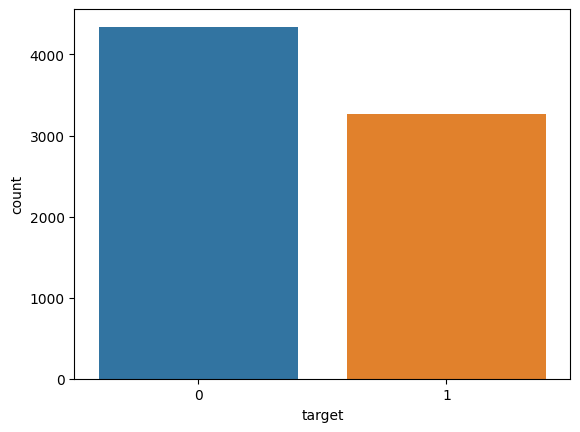

In [ ]:
sns.countplot(train_df, x="target")

In [ ]:
# print('length of data:',len(train_df))
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
#visiualation with text
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
My Instagram just blew up apparently I was featured on I am jazz tonight. How cool is that love her

---

Target: 0 (not real disaster)
Text:
nikoniko12022: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.

---

Target: 1 (real disaster)
Text:
Some people are really natural disaster too

---

Target: 0 (not real disaster)
Text:
iCASEIT - MFi Certified Lightning Cable - 1m http://t.co/b32Jmvsb1E http://t.co/XKMiJGY59T

---

Target: 0 (not real disaster)
Text:
@DarkNdTatted pull up Holmes!

---



In [ ]:
train_df=train_df.drop(['id','keyword','location'],axis=1)
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


#Data Preprocessing


We will create a few functions for doing some text preprocessing:

Lowercase all the text

Replace some abbreviations

Remove stopwords (words such as 'and', 'the','is')

Lemmatization (convert words to base form)

Remove HTML tags

Remove URL

Remove special characters

In [ ]:
import re
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization

In [ ]:
X=train_df['text'].to_numpy()
y=train_df['target'].to_numpy()

In [ ]:
# Use train_test_split to split training data into training and validation sets
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(X, y,test_size=0.1, random_state=42) # random state for reproducibility

In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
print(len(train_sentences))
print(len(train_labels))
print(len(val_sentences))
print(len(val_labels))

6851
6851
762
762


In [ ]:
train_sentences[:7]

array(["'McFadden Reportedly to Test Hamstring Thursday' via @TeamStream http://t.co/jWq4KvJH2j",
       'w--=-=-=-[ NEMA warns Nigerians to prepare for drought http://t.co/5uoOPhSqU3',
       "When I was cooking earlier I got electrocuted some crucial ?????? now I'm psychic lol",
       "I'm On Fire.  http://t.co/WATsmxYTVa",
       "More than 40 families affected by the fatal outbreak of Legionnaires' disease in Edinburgh are to sue two comp... http://t.co/vsoXioOy78",
       'Why do u ruin everything?  @9tarbox u ruined the sour cream and u put a brick of cheese in the freezer..dummy',
       'http://t.co/c1H7JECFrV @RoyalCarribean do your passengers know about the mass murder that takes place in the #FaroeIslands every year?'],
      dtype=object)

In [ ]:
train_labels[:7]

array([0, 1, 0, 0, 1, 0, 1])

#Converting text to number
tokenization (straight mapping from word to number)

embedding (richer representation of relationships between tokens) use feature vector

pre-trained word embeddings, Word2vec embeddings, GloVe embeddings

In [ ]:
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", #Text will be lowercased and all punctuation removed.
                                    split="whitespace", #Split on whitespace.
                                    ngrams=None, # create groups of n-words? .Passing None means that no ngrams will be created.
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=15) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

The vocabulary for the layer must be either supplied on construction or learned via adapt(). When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them.

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[282,   3, 206,   4,  13, 674,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

#Creating an Embedding using an Embedding Layer

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=10000, # set input shape *The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=15, # how long is each input
                             name="embedding_1")

embedding

In [ ]:
# Create sample sentence and embeddding it
sample_sentence = "There's a flood in my street!"
sample_embed = embedding(text_vectorizer([sample_sentence]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00451273,  0.01184746, -0.03505431, ...,  0.00057537,
          0.00055574, -0.00131048],
        [-0.01149514,  0.03956481,  0.03460157, ..., -0.02090938,
          0.00527253,  0.01357089],
        [-0.02386671, -0.04142884,  0.01172851, ...,  0.01261058,
         -0.03138964, -0.00064812],
        ...,
        [ 0.04788769, -0.04445522, -0.02384793, ...,  0.00354773,
          0.0492664 ,  0.01721847],
        [ 0.04788769, -0.04445522, -0.02384793, ...,  0.00354773,
          0.0492664 ,  0.01721847],
        [ 0.04788769, -0.04445522, -0.02384793, ...,  0.00354773,
          0.0492664 ,  0.01721847]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding,Each token in the sentence gets turned into a length 128 feature vector.
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00451273,  0.01184746, -0.03505431, -0.01302111,  0.02397453,
       -0.00358132,  0.04897979, -0.02244072, -0.02980735, -0.01444609,
        0.02373601, -0.00995389,  0.00878181,  0.04501771,  0.03845234,
        0.03104473, -0.01129477,  0.02124137,  0.00776489,  0.03952895,
       -0.0095305 , -0.00650474, -0.0097859 , -0.00230496,  0.03755568,
        0.00610881, -0.01889727,  0.02926556, -0.04467784,  0.04370887,
       -0.03059056, -0.04890817,  0.03812278,  0.03515314, -0.01502843,
       -0.01420997,  0.03465733,  0.04104481, -0.04541431, -0.02900529,
        0.01499743,  0.01080852,  0.00468371, -0.02284851,  0.02850784,
        0.03833458,  0.0398082 , -0.0378835 , -0.04524732, -0.02819086,
        0.04921863,  0.00444119,  0.00090937,  0.03922936, -0.04462787,
        0.04123667,  0.00481809, -0.0391446 ,  0.04903844,  0.0377345 ,
       -0.01145888,  0.03542655, -0.03845499, -0.00557976,  0.04474511,
       -0.022745

## Model 0: Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 77.82%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")
  model_results = {'accuracy': model_accuracy,
             'precision': model_precision,
             'recall': model_recall,
             'f1': model_f1}

  return model_results


In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 77.82152230971128,
 'precision': 0.792992256322435,
 'recall': 0.7782152230971129,
 'f1': 0.7703527809038113}

#Model 1: A simple dense model

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs= layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 14s 42ms/step - loss: 0.6112 - accuracy: 0.6920 - val_loss: 0.5408 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4391 - accuracy: 0.8181 - val_loss: 0.4829 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3448 - accuracy: 0.8622 - val_loss: 0.4748 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2824 - accuracy: 0.8914 - val_loss: 0.4881 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2358 - accuracy: 0.9114 - val_loss: 0.5016 - val_accuracy: 0.7848


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.5016 - accuracy: 0.7848


[0.5015801191329956, 0.7847769260406494]

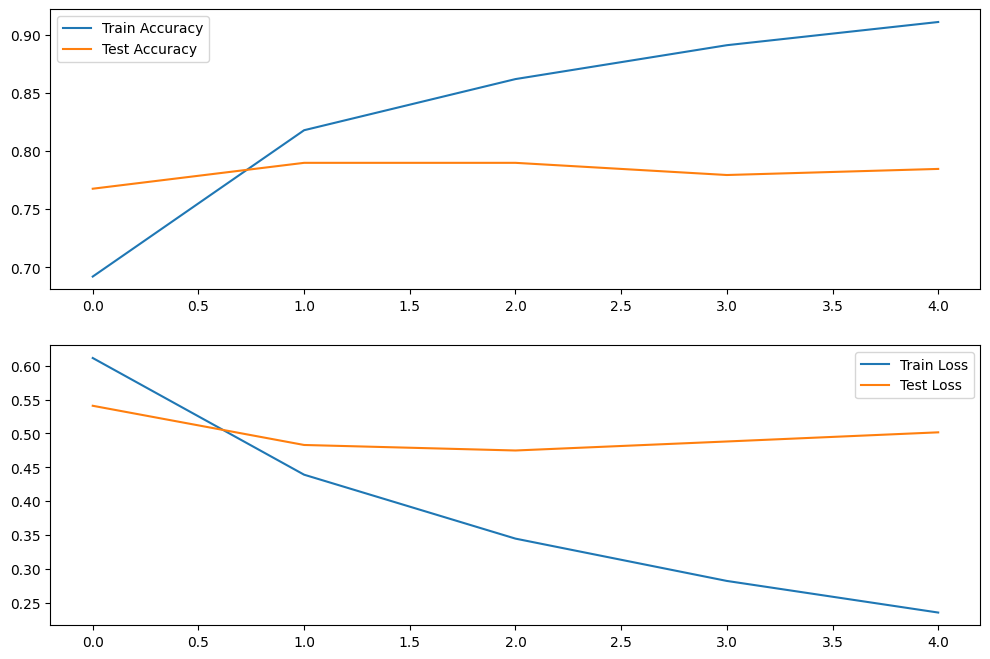

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].plot(model_1_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(model_1_history.history['val_accuracy'], label='Test Accuracy')

ax[1].plot(model_1_history.history['loss'], label='Train Loss')
ax[1].plot(model_1_history.history['val_loss'], label='Test Loss')

ax[0].legend()
ax[1].legend()

In [ ]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 4ms/step


array([[0.02900793],
       [0.16210504],
       [0.30420148],
       [0.02148784],
       [0.56472325],
       [0.12600775],
       [0.01864194],
       [0.25303674],
       [0.10023813],
       [0.90771514]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'precision': 0.7877219146138155,
 'recall': 0.7847769028871391,
 'f1': 0.78147040063991}

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 77.82, New accuracy: 78.48, Difference: 0.66
Baseline precision: 0.79, New precision: 0.79, Difference: -0.01
Baseline recall: 0.78, New recall: 0.78, Difference: 0.01
Baseline f1: 0.77, New f1: 0.78, Difference: 0.01


#Model2 :LSTM model

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=10000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=15,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20231119-091507
Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.5132 - accuracy: 0.7468 - val_loss: 0.4635 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3141 - accuracy: 0.8736 - val_loss: 0.5269 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2160 - accuracy: 0.9221 - val_loss: 0.5273 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1448 - accuracy: 0.9464 - val_loss: 0.6727 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1005 - accuracy: 0.9591 - val_loss: 0.9955 - val_accuracy: 0.7375


In [ ]:
model_2.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.7375


[0.9955224990844727, 0.7375327944755554]

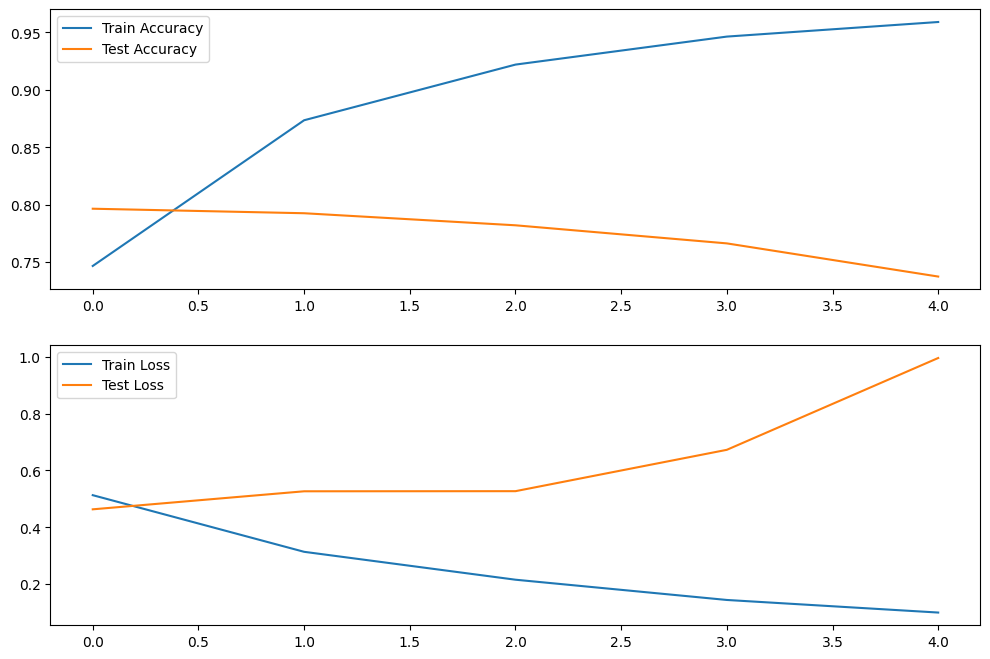

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].plot(model_2_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(model_2_history.history['val_accuracy'], label='Test Accuracy')

ax[1].plot(model_2_history.history['loss'], label='Train Loss')
ax[1].plot(model_2_history.history['val_loss'], label='Test Loss')

ax[0].legend()
ax[1].legend()

In [ ]:
# Make predictions (these come back in the form of probabilities)
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 3ms/step


array([[1.3714234e-03],
       [2.1044651e-01],
       [8.7836748e-03],
       [2.4347247e-03],
       [9.9886227e-01],
       [4.7735073e-02],
       [5.1451824e-04],
       [2.1018652e-02],
       [1.0009199e-02],
       [9.9898046e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs)) # squeeze removes single dimensions
model_2_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_1 metrics
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.75328083989501,
 'precision': 0.7368689585974882,
 'recall': 0.7375328083989501,
 'f1': 0.7370728593035402}

## Transfer Learning with LSTM model

In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.0 MB/s eta 0:00:00


In [ ]:
# from transformers import BertModel, BertTokenizer

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# # Load pre-trained BERT model and tokenizer
# bert_model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize input data

# # Get BERT embeddings
# bert_outputs = bert_model(inputs)

# # Extract embeddings from BERT output (e.g., using the output from the last layer)
# bert_embeddings = bert_outputs.last_hidden_state

# # Build LSTM model on top of BERT embeddings
# model = Sequential()
# model.add(LSTM(units=64, input_shape=(10000, bert_embeddings.shape[-1]), return_sequences=True))
# model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
import tensorflow_hub as hub

# Specify the URL of the pre-trained BERT model
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

# Load the BERT model
bert_model = hub.KerasLayer(module_url)


In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (1,128),
                      output_shape: int = 2,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:


    # Create base model
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    embed = hub.load(module_url)


    sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=input_shape,
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

   # Create model using the Sequential API
    model = tf.keras.Sequential([
    sentence_encoder_layer, # take in sentences and then encode them into an embedding
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")],
    name="model_3_USE")


# x = model_2_embedding(x)

    inputs = layers.Input(shape=(1,), dtype="string")
    x = text_vectorizer(inputs)
    x = embed(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model



In [ ]:
# Create an instance of model_2 with our new function
model_2 = create_base_model()

ValueError: ignored

In [ ]:
# Train a classifier on top of pretrained embeddings
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

#Transfer Learning in NLP Model 3
## Universal Sentence Encoder
Preprocessing
The module does not require preprocessing the data before applying the module, it performs best effort text input preprocessing inside the graph.

In [ ]:
# Example of pretrained embedding with universal sentence encoder
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url) # load Universal Sentence Encoder

In [ ]:
embed_samples = embed([sample_sentence,
                      "The cryptic words that guided pilots on the Hiroshima bombing mission."])

print(embed_samples)

tf.Tensor(
[[-0.01157028  0.0248591   0.02878048 ... -0.00186124  0.02315826
  -0.01485021]
 [ 0.00490402 -0.02796831 -0.03765553 ... -0.0037562   0.01253059
   0.00085128]], shape=(2, 512), dtype=float32)


In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_3 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_3_USE")

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231115-191726
Epoch 1/5
215/215 [==============================] - 8s 21ms/step - loss: 0.5098 - accuracy: 0.7811 - val_loss: 0.4295 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4192 - accuracy: 0.8140 - val_loss: 0.4101 - val_accuracy: 0.8228
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4057 - accuracy: 0.8213 - val_loss: 0.4037 - val_accuracy: 0.8189
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3967 - accuracy: 0.8270 - val_loss: 0.4017 - val_accuracy: 0.8202
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3902 - accuracy: 0.8292 - val_loss: 0.3997 - val_accuracy: 0.8215


In [ ]:
model_3.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 12ms/step - loss: 0.3997 - accuracy: 0.8215


[0.3996725380420685, 0.8215222954750061]

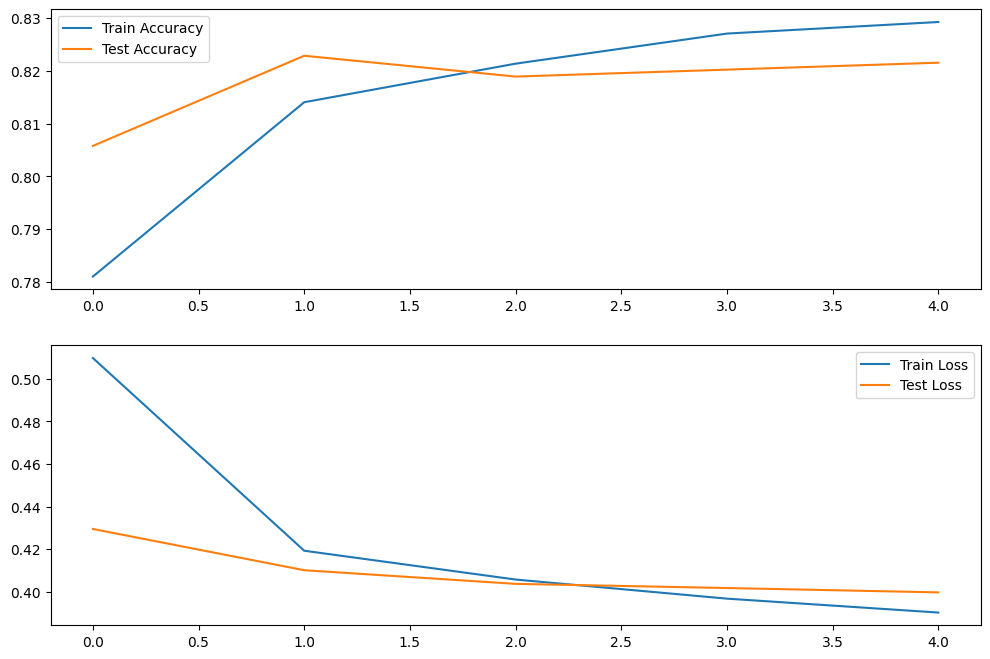

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].plot(model_3_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(model_3_history.history['val_accuracy'], label='Test Accuracy')

ax[1].plot(model_3_history.history['loss'], label='Train Loss')
ax[1].plot(model_3_history.history['val_loss'], label='Test Loss')

ax[0].legend()
ax[1].legend()

In [ ]:
# Make predictions (these come back in the form of probabilities)
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 1s 11ms/step


array([[0.08245023],
       [0.08589791],
       [0.4375129 ],
       [0.14845525],
       [0.28926212],
       [0.09902278],
       [0.13154517],
       [0.0888804 ],
       [0.32596743],
       [0.7734986 ]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs)) # squeeze removes single dimensions
model_3_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0.], dtype=float32)>

#GRU Model 4

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=10000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=15,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
#layers.GRU(64, return_sequences=True)
print(x.shape)
x = layers.GRU(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 15, 128)
(None, 64)


In [ ]:
# Compile GRU model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Fit model
model_4_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20231115-080543
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5101 - accuracy: 0.7761 - val_loss: 0.4283 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4183 - accuracy: 0.8151 - val_loss: 0.4092 - val_accuracy: 0.8176
Epoch 3/5
215/215 [==============================] - 7s 31ms/step - loss: 0.4040 - accuracy: 0.8227 - val_loss: 0.4024 - val_accuracy: 0.8202
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3944 - accuracy: 0.8285 - val_loss: 0.4009 - val_accuracy: 0.8228
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3876 - accuracy: 0.8305 - val_loss: 0.3989 - val_accuracy: 0.8163


In [ ]:
model_4.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4475


[0.6939098238945007, 0.44750654697418213]

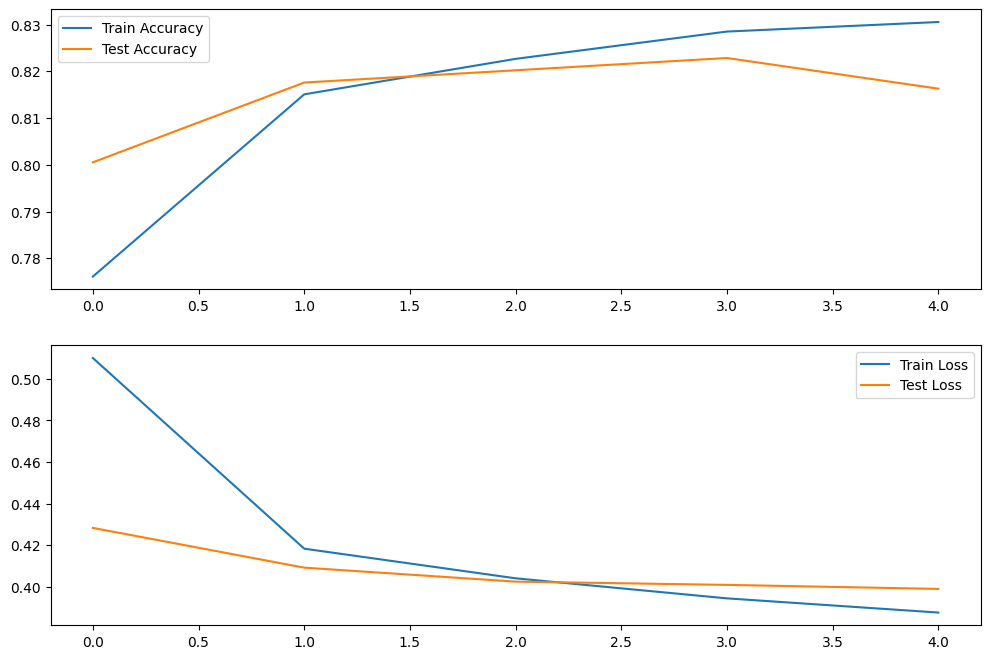

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].plot(model_4_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(model_4_history.history['val_accuracy'], label='Test Accuracy')

ax[1].plot(model_4_history.history['loss'], label='Train Loss')
ax[1].plot(model_4_history.history['val_loss'], label='Test Loss')

ax[0].legend()
ax[1].legend()

In [ ]:
# Make predictions (these come back in the form of probabilities)
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 1s 4ms/step


array([[0.50387436],
       [0.50672084],
       [0.49032182],
       [0.5060686 ],
       [0.4924233 ],
       [0.48955506],
       [0.4935132 ],
       [0.50085044],
       [0.5028417 ],
       [0.5042736 ]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs)) # squeeze removes single dimensions
model_4_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1.], dtype=float32)>

#Bidirectional RNN model5

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=10000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=15,
                                     name="embedding_5")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Bidirectional")

In [ ]:
# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_5.summary()

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20231115-172519
Epoch 1/5
215/215 [==============================] - 16s 50ms/step - loss: 0.5111 - accuracy: 0.7465 - val_loss: 0.4612 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3130 - accuracy: 0.8718 - val_loss: 0.4854 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2074 - accuracy: 0.9241 - val_loss: 0.5530 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1336 - accuracy: 0.9552 - val_loss: 0.8058 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0924 - accuracy: 0.9660 - val_loss: 0.9103 - val_accuracy: 0.7690


In [ ]:
model_5.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.9103 - accuracy: 0.7690


[0.9103345274925232, 0.7690288424491882]

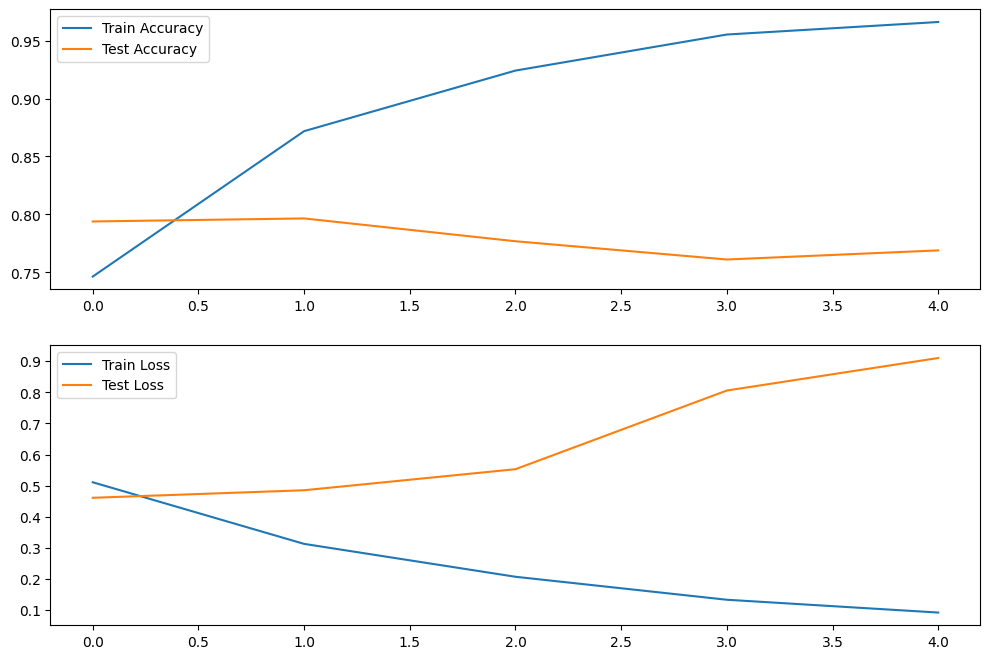

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].plot(model_5_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(model_5_history.history['val_accuracy'], label='Test Accuracy')

ax[1].plot(model_5_history.history['loss'], label='Train Loss')
ax[1].plot(model_5_history.history['val_loss'], label='Test Loss')

ax[0].legend()
ax[1].legend()

In [ ]:
# Make predictions (these come back in the form of probabilities)
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 1s 6ms/step


array([[3.4509625e-03],
       [9.6527468e-03],
       [1.7835388e-03],
       [7.5687090e-04],
       [7.4084175e-01],
       [4.2162966e-03],
       [5.0661224e-04],
       [1.0469783e-02],
       [9.1658114e-03],
       [9.9838352e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs)) # squeeze removes single dimensions
model_5_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0.], dtype=float32)>

# CNN model 6

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
from keras.layers import Conv1D

model_6_embedding = layers.Embedding(input_dim=10000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=15,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_6_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x=layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")



In [ ]:
# Compile Conv1D model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
# Fit the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231115-184239
Epoch 1/5
215/215 [==============================] - 29s 82ms/step - loss: 0.5569 - accuracy: 0.7068 - val_loss: 0.4804 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3123 - accuracy: 0.8762 - val_loss: 0.5159 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1679 - accuracy: 0.9475 - val_loss: 0.6260 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1081 - accuracy: 0.9670 - val_loss: 0.6905 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0848 - accuracy: 0.9747 - val_loss: 0.7690 - val_accuracy: 0.7651


In [ ]:
model_6.evaluate(val_sentences,val_labels)
#Average pooling :73
#Max pooling :75(with 32 filter)
#Max pooling :76(with 64 filter)
#Max pooling : (with 2 dense layers and 32 kernel size)

24/24 [==============================] - 0s 4ms/step - loss: 0.7690 - accuracy: 0.7651


[0.7689525485038757, 0.7650918364524841]

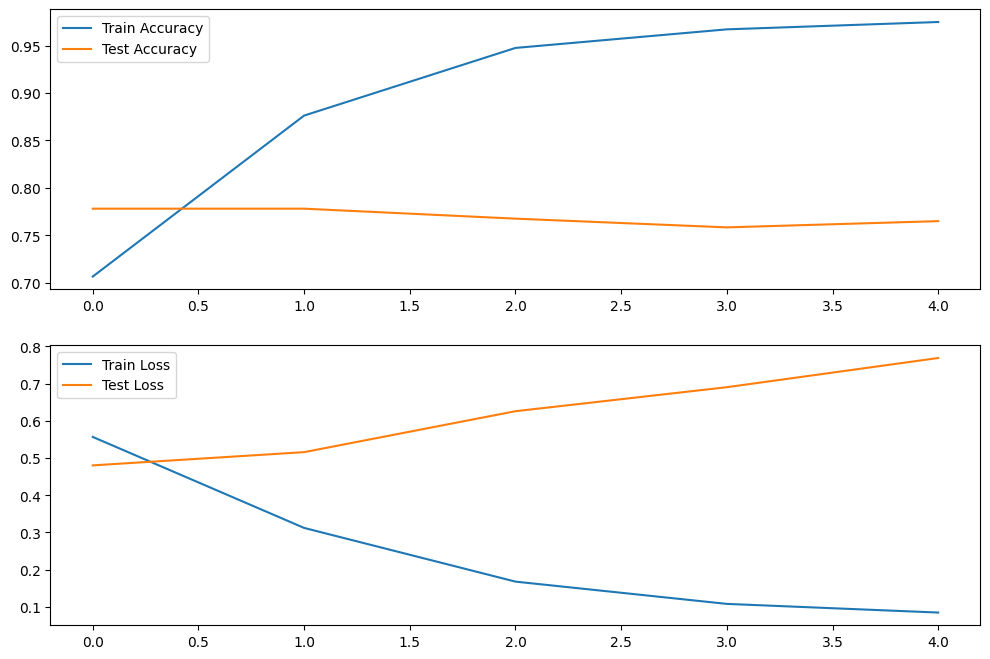

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].plot(model_6_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(model_6_history.history['val_accuracy'], label='Test Accuracy')

ax[1].plot(model_6_history.history['loss'], label='Train Loss')
ax[1].plot(model_6_history.history['val_loss'], label='Test Loss')

ax[0].legend()
ax[1].legend()

In [ ]:
# Make predictions with model_5
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.00225108],
       [0.0679078 ],
       [0.03344836],
       [0.00852747],
       [0.10244922],
       [0.00415316],
       [0.00601315],
       [0.01081485],
       [0.01064836],
       [0.99663275]], dtype=float32)

In [ ]:
# Convert model_5 prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics
model_6_results = calculate_results(y_true=val_labels,
                                   y_pred=model_6_preds)
model_6_results

{'accuracy': 76.50918635170603,
 'precision': 0.7724599180454719,
 'recall': 0.7650918635170604,
 'f1': 0.7589670150350715}

In [ ]:
# Compare model_5 results to baseline  {'accuracy': 78.74015748031496
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 77.82, New accuracy: 76.51, Difference: -1.31
Baseline precision: 0.79, New precision: 0.77, Difference: -0.02
Baseline recall: 0.78, New recall: 0.77, Difference: -0.01
Baseline f1: 0.77, New f1: 0.76, Difference: -0.01


In [ ]:
from keras.layers import Conv1D

model = keras.models.Sequential()

model.add(Conv1D(1, kernel_size=5, input_shape = (120, 3)))

model.summary()